SETUP AND OBSERVATIONAL ANALYSIS

In [489]:
# Importing libraries/functions to be used
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.api.models import Sequential
from keras.api.layers import LSTM
from keras.api.layers import Dense
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split

In [490]:
# Import dataset from yahoo finance consisting of [Date, Opening Price, Closing Price]
dataset = yf.download(tickers = "^GSPC", period="1y")
dataset = dataset[['Open', 'Close']]
dataset = dataset.reset_index()
dataset

[*********************100%%**********************]  1 of 1 completed


,Date,Open,Close
0,2023-10-23,4210.399902,4217.040039
1,2023-10-24,4235.790039,4247.680176
2,2023-10-25,4232.419922,4186.770020
3,2023-10-26,4175.990234,4137.229980
4,2023-10-27,4152.930176,4117.370117
...,...,...,...
247,2024-10-16,5816.580078,5842.470215
248,2024-10-17,5875.620117,5841.470215
249,2024-10-18,5859.430176,5864.669922
250,2024-10-21,5857.819824,5853.979980


In [491]:
# Transform the raw data into a pandas dataframe consisting of [Date, OPS]
# OPS = ((Opening Price - Closing Price of previous day) / Closing Price of previous day) * 100
# i.e. it refers to the percentage change in price overnight
ops = []
for i in range(1, len(dataset['Open'] + 1)):
    result = ((dataset['Open'][i] - dataset['Close'][i-1]) / dataset['Close'][i-1]) * 100
    ops.append(result)
ops = pd.DataFrame({'OPS': ops})

time_series = pd.concat([dataset['Date'], ops], axis=1)
time_series = time_series.dropna()
#time_series['OPS'] = time_series['OPS'].shift(1)
#time_series = time_series.drop(0)
#time_series = time_series.drop(index=1)
#time_series = time_series.reset_index()
#time_series = time_series.drop(['index'], axis=1)
time_series

,Date,OPS
0,2023-10-23,0.444625
1,2023-10-24,-0.359261
2,2023-10-25,-0.257473
3,2023-10-26,0.379486
4,2023-10-27,0.534808
...,...,...
246,2024-10-15,0.022704
247,2024-10-16,0.567395
248,2024-10-17,0.307456
249,2024-10-18,-0.116803


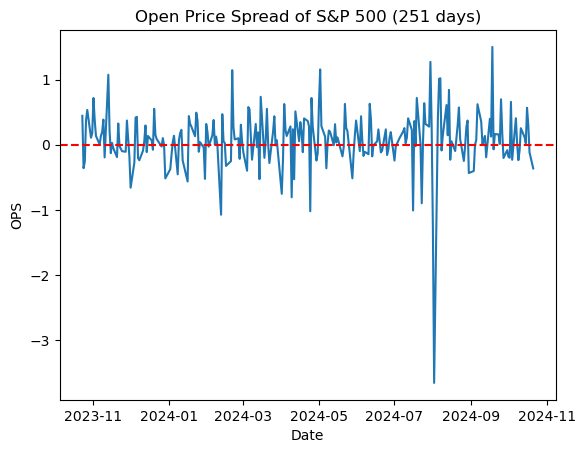

In [492]:
# Plotting the time series data (OPS) for observing trends and seasons
plt.plot(time_series['Date'], time_series['OPS'])
plt.axhline(y=0, linestyle='--', color='red')
plt.title('Open Price Spread of S&P 500 (' + str(len(time_series['OPS'])) + ' days)')
plt.xlabel('Date')
plt.ylabel('OPS')
plt.show()

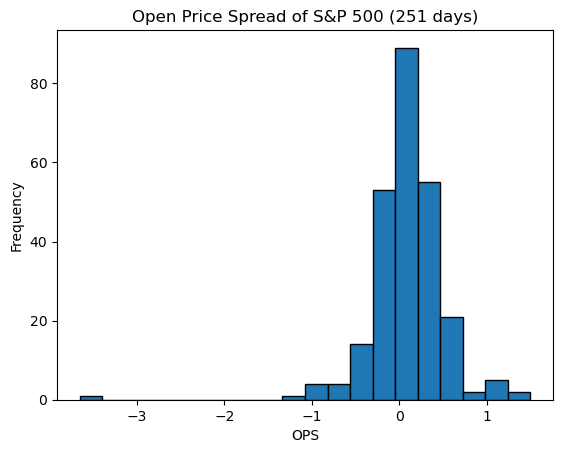

In [493]:
# Plotting the spread of OPS
plt.hist(time_series['OPS'], bins=20, edgecolor="black")
plt.title('Open Price Spread of S&P 500 (' + str(len(time_series['OPS'])) + ' days)')
plt.xlabel('OPS')
plt.ylabel('Frequency')
plt.show()

LSTM MODEL

This guide/tutorial was mostly used to help with the creation of this model:

Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras, Jason Brownlee, Machine Learning Mastery <https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/>

How to Tune LSTM Hyperparameters with Keras for Time Series Forecasting, Jason Brownlee, Machine Learning Mastery <https://machinelearningmastery.com/tune-lstm-hyperparameters-keras-time-series-forecasting/>

In [494]:
# Check to see if data is stationary using the Augmented Dicky Fuller Test (adfuller)
# Stationary data is required for timeseries analysis/prediction
data = time_series['OPS']
stationary_check = adfuller(data)
print('ADF Statistic: ', stationary_check[0])
print('p-value: ', stationary_check[1])
if(stationary_check[1] < 0.05):
    print('Data is stationary')
else:
    print('Data is not stationary')

ADF Statistic:  -8.686445046031537
p-value:  4.1509930993540186e-14
Data is stationary


In [495]:
# The LSTM model requires a specific input, this function helps achieve this by creating two arrays where X is OPS at t, and Y is OPS at t+1
def create_dataset(dataset, look_back=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
 return np.array(dataX), np.array(dataY)

In [496]:
# Dataset needs to be transformed (normalised) to fit the model
dataset = data.values.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [497]:
# Set seed for reproducability 
tf.random.set_seed(10)

# Create accuracy table
accuracy_table = pd.DataFrame(columns=['Train:Test Split','Mean Squared Error','Mean Absolute Error', 'R-Squared Value'])
accuracy_table = accuracy_table.set_index('Train:Test Split')

In [498]:
# Split data into training and testing sets, 80:20 split 
train, test = train_test_split(dataset, test_size=0.20, shuffle=False)
print(len(dataset))
print(len(train))
print(len(test))

251
200
51


In [499]:
# Split into X (OPS at t) and Y (OPS at t+1)
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(len(trainX))
print(len(testX))
print(len(trainY))
print(len(testY))

198
49
198
49


In [500]:
# Reshape data into [Samples, Time Steps, Features] so it can fit the model
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Epoch 1/100


c:\Users\olive\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


198/198 - 1s - 5ms/step - loss: 0.3129
Epoch 2/100
198/198 - 0s - 988us/step - loss: 0.0382
Epoch 3/100
198/198 - 0s - 1ms/step - loss: 0.0089
Epoch 4/100
198/198 - 0s - 1ms/step - loss: 0.0086
Epoch 5/100
198/198 - 0s - 964us/step - loss: 0.0086
Epoch 6/100
198/198 - 0s - 1ms/step - loss: 0.0086
Epoch 7/100
198/198 - 0s - 1ms/step - loss: 0.0086
Epoch 8/100
198/198 - 0s - 882us/step - loss: 0.0086
Epoch 9/100
198/198 - 0s - 1ms/step - loss: 0.0086
Epoch 10/100
198/198 - 0s - 1ms/step - loss: 0.0086
Epoch 11/100
198/198 - 0s - 1ms/step - loss: 0.0086
Epoch 12/100
198/198 - 0s - 1ms/step - loss: 0.0086
Epoch 13/100
198/198 - 0s - 1ms/step - loss: 0.0086
Epoch 14/100
198/198 - 0s - 1ms/step - loss: 0.0086
Epoch 15/100
198/198 - 0s - 1ms/step - loss: 0.0086
Epoch 16/100
198/198 - 0s - 1ms/step - loss: 0.0085
Epoch 17/100
198/198 - 0s - 1ms/step - loss: 0.0085
Epoch 18/100
198/198 - 0s - 1ms/step - loss: 0.0085
Epoch 19/100
198/198 - 0s - 1ms/step - loss: 0.0085
Epoch 20/100
198/198 - 0s -

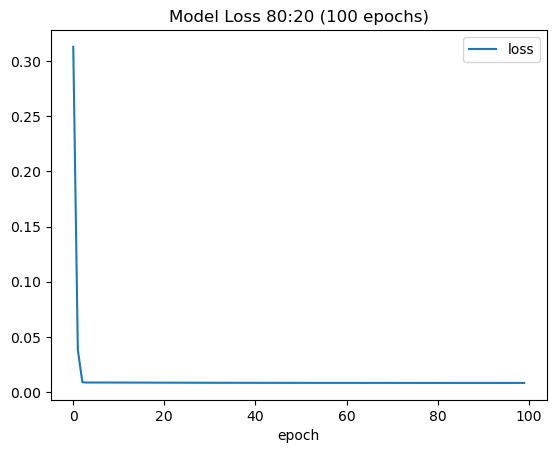

In [501]:
# Fitting model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# Plotting loss
plt.plot(history.history['loss'], label='loss')
plt.title('Model Loss 80:20 (100 epochs)')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [502]:
# Make prediction
testPredict = model.predict(testX)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


In [503]:
# Inverse the transformation
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

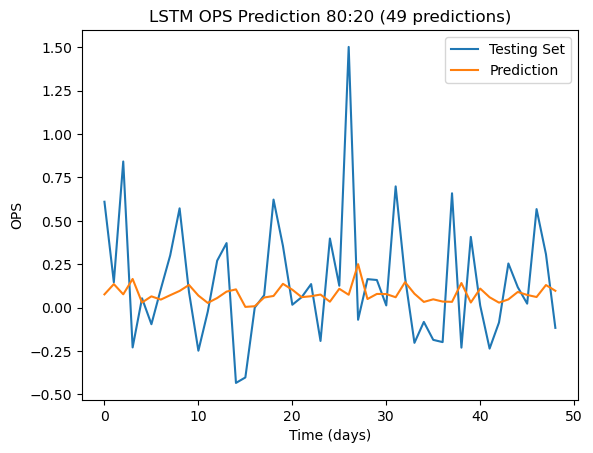

In [504]:
# Plot prediction
plt.plot(testY[0], label='Testing Set')
plt.plot(testPredict[:,0], label='Prediction')
plt.title('LSTM OPS Prediction 80:20 (' + str(len(testPredict[:,0])) + ' predictions)')
plt.xlabel('Time (days)')
plt.ylabel('OPS')
plt.legend()
plt.show()


In [505]:
# Evaluate
mse = (mean_squared_error(testY[0], testPredict[:,0]))
mae = (mean_absolute_error(testY[0], testPredict[:,0]))
r2 = (r2_score(testY[0], testPredict[:,0]))
accuracy_table.loc["80:20"] = {'Mean Squared Error' : mse, 'Mean Absolute Error' : mae, 'R-Squared Value' : r2}
accuracy_table

,Mean Squared Error,Mean Absolute Error,R-Squared Value
Train:Test Split,,,
80:20,0.133306,0.259371,-0.069456


LSTM for 90:10 95:5 97.5:2.5

c:\Users\olive\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


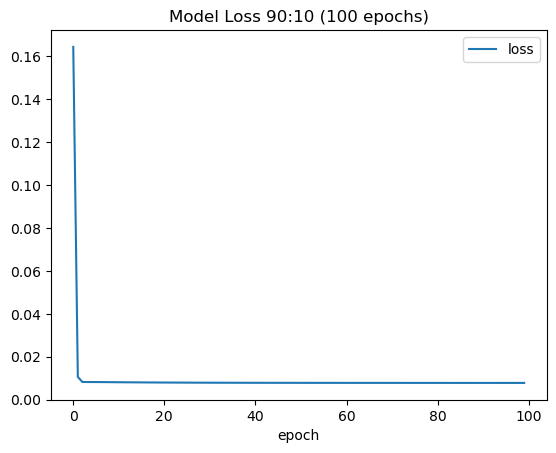

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


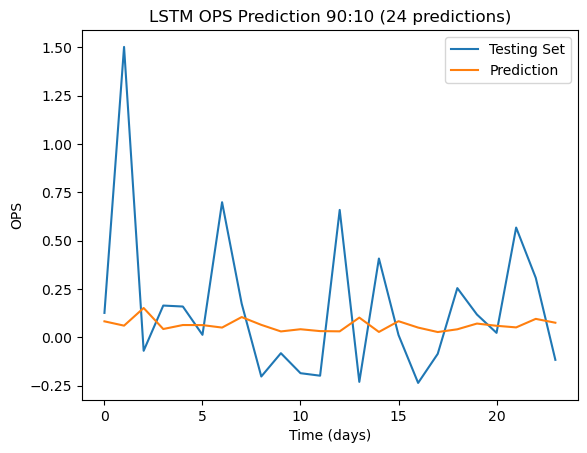

c:\Users\olive\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


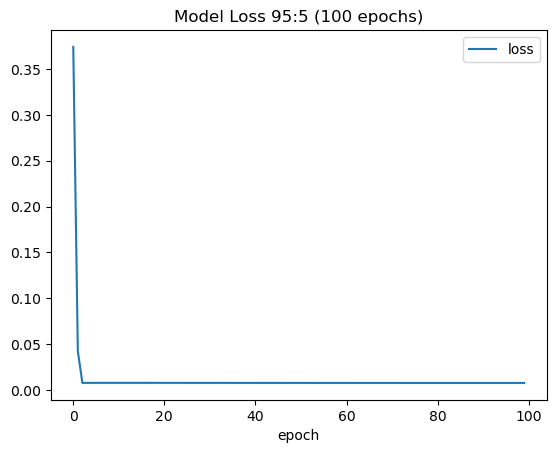

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


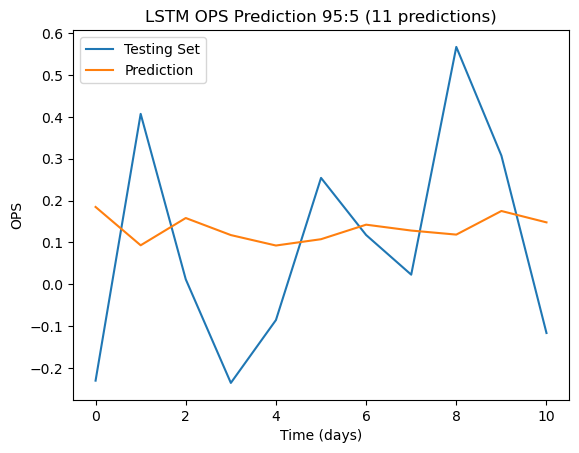

c:\Users\olive\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


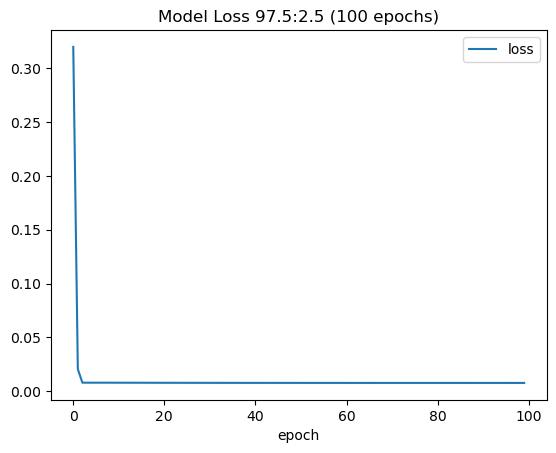

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


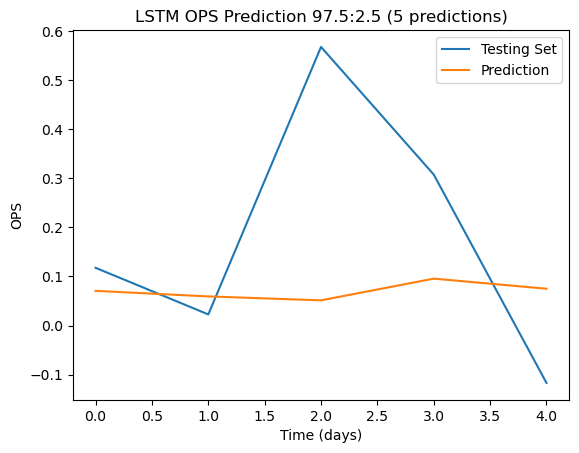

,Mean Squared Error,Mean Absolute Error,R-Squared Value
Train:Test Split,,,
80:20,0.133306,0.259371,-0.069456
90:10,0.163167,0.273211,-0.087654
95:5,0.070174,0.230081,-0.107266
97.5:2.5,0.070308,0.200661,-0.241966


In [506]:
#Repeating experiement

#epochs = [100, 500, 1000]
sample_size = [0.1, 0.05, 0.025] # 10% 5% 2.5%
sample_sizeS = ["90:10", "95:5", "97.5:2.5"]

# Repeat 3 times
for i in range(3):
    # Split data according to sample_size
    train, test = train_test_split(dataset, test_size=sample_size[i], shuffle=False)

    # Split into X and Y
    look_back = 1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # Reshape data
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    # Fit model
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

    # Plot loss
    plt.plot(history.history['loss'], label='loss')
    plt.title('Model Loss ' + sample_sizeS[i] + ' (100 epochs)')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

    # Predict
    testPredict = model.predict(testX)

    # Inverse Transformation
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])

    # Evaluation
    mse = (mean_squared_error(testY[0], testPredict[:,0]))
    mae = (mean_absolute_error(testY[0], testPredict[:,0]))
    r2 = (r2_score(testY[0], testPredict[:,0]))

    # Plot results
    plt.plot(testY[0], label='Testing Set')
    plt.plot(testPredict[:,0], label='Prediction')
    plt.title('LSTM OPS Prediction ' + sample_sizeS[i] + ' (' + str(len(testPredict[:,0])) + ' predictions)')
    plt.xlabel('Time (days)')
    plt.ylabel('OPS')
    plt.legend()
    plt.show()

    # Add to accuracy table
    accuracy_table.loc[sample_sizeS[i]] = {'Mean Squared Error' : mse, 'Mean Absolute Error' : mae, 'R-Squared Value' : r2}

# Show accuracy table
accuracy_table